In [1]:
import numpy as np
import pandas as pd
import random

# Define constants & relationships
materials = ['Steel', 'Concrete', 'Wood', 'Composite']
maintenance_levels = ['Low', 'Medium', 'High']
environments = ['Harsh', 'Normal', 'Mild']
crack_options = ['yes', 'no']

# Base lifespan for materials (years)
material_lifespan = {'Steel': 80, 'Concrete': 100, 'Wood': 50, 'Composite': 90}

def predict_life_expectancy(age, material, maintenance, env, cracks, corrosion):
    # Base lifespan adjusted by factors
    base = material_lifespan[material]

    # Maintenance impact: High adds 20%, Medium neutral, Low subtracts 30%
    maintenance_factor = {'Low': 0.7, 'Medium': 1.0, 'High': 1.2}[maintenance]

    # Environmental impact: Harsh reduces lifespan by 25%, Mild increases by 10%
    env_factor = {'Harsh': 0.75, 'Normal': 1.0, 'Mild': 1.1}[env]

    # Cracks reduce lifespan by 15%
    crack_factor = 0.85 if cracks == 'yes' else 1.0

    # Corrosion penalty: 2% reduction per corrosion level
    corrosion_factor = 1.0 - (corrosion * 0.02)

    # Traffic load penalty: 0.001% reduction per 1000 vehicles/day
    traffic_factor = 1.0 - (traffic_load / 100000) * 0.1  # Up to 10% reduction

    # Final lifespan calculation
    total_lifespan = base * maintenance_factor * env_factor * crack_factor * corrosion_factor * traffic_factor
    remaining_life = max(0, total_lifespan - age)  # Ensure non-negative

    return round(remaining_life, 2)

data = []
for _ in range(5000):
    material = random.choice(materials)

    # Age: Ensure it doesn't exceed realistic limits for the material
    max_age = material_lifespan[material]
    age = np.random.randint(1, int(max_age * 0.9))  # Bridges rarely reach 90% of max age

    # Span Length: Most bridges are 20-200m, with fewer very long spans
    span_length = round(np.random.lognormal(mean=3.0, sigma=0.5), 2)  # Log-normal distribution

    # Traffic Load: 80% of bridges have <50k vehicles/day
    traffic_load = np.random.choice(
        [np.random.randint(100, 50000), np.random.randint(50000, 100000)],
        p=[0.8, 0.2]
    )

    # Maintenance Level: High maintenance is less common but depends on traffic
    maintenance = random.choices(
        maintenance_levels,
        weights=[0.4, 0.4, 0.2] if traffic_load > 30000 else [0.2, 0.5, 0.3]  # High-traffic bridges get more maintenance
    )[0]

    # Environmental Conditions: Harsh env increases corrosion risk
    env = random.choices(environments, weights=[0.3, 0.5, 0.2])[0]

    # Cracks: More likely with Low maintenance or Harsh environments
    crack_prob = 0.5 if maintenance == 'Low' or env == 'Harsh' else 0.1
    cracks = 'yes' if np.random.random() < crack_prob else 'no'

    # Corrosion: Depends on material and maintenance
    if material == 'Steel':
        base_corrosion = np.random.randint(3, 8)  # Steel corrodes more
    else:
        base_corrosion = np.random.randint(1, 6)

    corrosion = max(0, min(10,
        base_corrosion
        + (-2 if maintenance == 'High' else 0)  # High maintenance reduces corrosion
        + (2 if env == 'Harsh' else 0)  # Harsh env increases corrosion
    ))

    # Calculate remaining life
    predicted_life = predict_life_expectancy(age, material, maintenance, env, cracks, corrosion)

    data.append([
        f"BR-{_+1}", age, material, span_length, traffic_load,
        maintenance, env, cracks, corrosion, predicted_life
    ])

df = pd.DataFrame(data, columns=[
    'bridge_id', 'age', 'material', 'span_length', 'traffic_load',
    'maintenance_level', 'environmental_conditions', 'cracks_detected',
    'corrosion_level', 'predicted_life_years'
])

In [9]:
df.shape

(5000, 10)

In [3]:
df.sample(5)

,bridge_id,age,material,span_length,traffic_load,maintenance_level,environmental_conditions,cracks_detected,corrosion_level,predicted_life_years
1673,BR-1674,11,Composite,13.58,31536,Low,Normal,yes,4,36.71
2326,BR-2327,40,Steel,24.94,25449,Medium,Normal,no,4,31.73
1399,BR-1400,9,Wood,22.47,40029,Low,Normal,no,2,23.26
2621,BR-2622,2,Concrete,47.59,32314,Medium,Normal,no,1,92.83
1288,BR-1289,34,Steel,10.19,35913,Medium,Harsh,no,9,13.43


In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bridge_id                 5000 non-null   object 
 1   age                       5000 non-null   int64  
 2   material                  5000 non-null   object 
 3   span_length               5000 non-null   float64
 4   traffic_load              5000 non-null   int64  
 5   maintenance_level         5000 non-null   object 
 6   environmental_conditions  5000 non-null   object 
 7   cracks_detected           5000 non-null   object 
 8   corrosion_level           5000 non-null   int64  
 9   predicted_life_years      5000 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 390.8+ KB


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
df = df.drop(columns=['bridge_id'])


In [16]:
categorical_cols = ['material', 'maintenance_level', 'environmental_conditions', 'cracks_detected']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    print(list(le.classes_))
    label_encoders[col] = le


['Composite', 'Concrete', 'Steel', 'Wood']
['High', 'Low', 'Medium']
['Harsh', 'Mild', 'Normal']
['no', 'yes']


In [17]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['predicted_life_years']))
X = pd.DataFrame(scaled_features, columns=df.columns[:-1])
y = df['predicted_life_years']


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import catboost as ct

In [20]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [21]:
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 1.47
Mean Squared Error (MSE): 3.84
Root Mean Squared Error (RMSE): 1.96
R² Score: 0.99


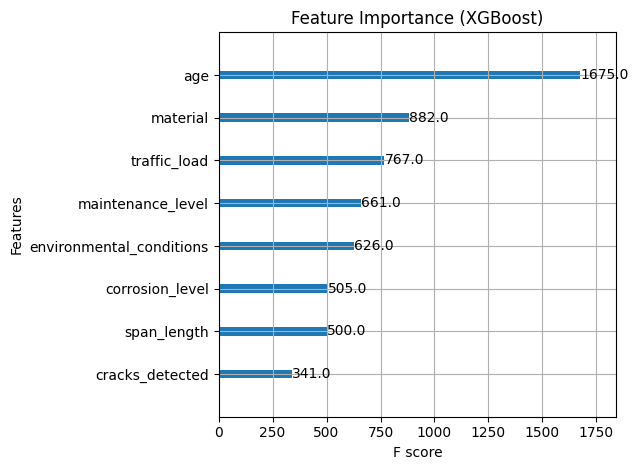

In [22]:
xgb.plot_importance(xgb_model)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


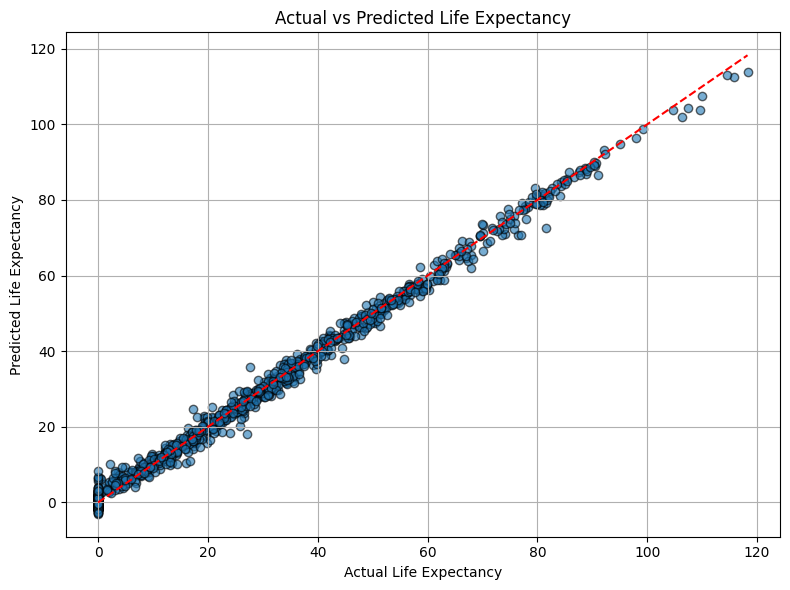

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Actual vs Predicted Life Expectancy")
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.tight_layout()
plt.show()


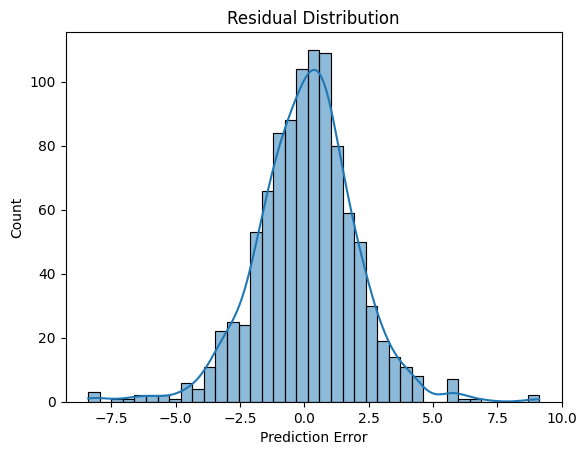

In [24]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.show()


In [25]:
X_train.head(1)

,age,material,span_length,traffic_load,maintenance_level,environmental_conditions,cracks_detected,corrosion_level
4227,-1.058113,-0.464615,-0.301676,0.441088,-0.235258,-1.381858,1.513816,-0.309402


In [26]:
df.head(1)

,age,material,span_length,traffic_load,maintenance_level,environmental_conditions,cracks_detected,corrosion_level,predicted_life_years
0,28,2,18.6,43139,2,0,1,5,15.92


In [27]:
['Composite', 'Concrete', 'Steel', 'Wood']
['High', 'Low', 'Medium']
['Harsh', 'Mild', 'Normal']
['no', 'yes']

['no', 'yes']

In [28]:
t1=np.array([59,3,1323,55349,0,2,0,5]).reshape(1,-1)

In [29]:
t1_scaled=scaler.transform(t1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [30]:
print(xgb_model.predict(t1_scaled))

[14.700413]


In [31]:
import joblib

joblib.dump(xgb_model, 'bridge_life_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [32]:
import joblib
for col, le in label_encoders.items():
    joblib.dump(le, f"{col}_encoder.pkl")


In [33]:
label_encoders.items()

dict_items([('material', LabelEncoder()), ('maintenance_level', LabelEncoder()), ('environmental_conditions', LabelEncoder()), ('cracks_detected', LabelEncoder())])

In [34]:
pip install catboost

In [2]:
import catboost # Corrected the typo in the module name from 'catbosst' to 'catboost'

In [1]:
import numpy as np
import pandas as pd
import random
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define constants & relationships
materials = ['Steel', 'Concrete', 'Wood', 'Composite']
maintenance_levels = ['Low', 'Medium', 'High']
environments = ['Harsh', 'Normal', 'Mild']

# Base lifespan for materials (years)
material_lifespan = {'Steel': 80, 'Concrete': 100, 'Wood': 50, 'Composite': 90}

data = []
for i in range(5000):
    material = random.choice(materials)
    max_age = material_lifespan[material]
    age = np.random.randint(1, int(max_age * 0.9))
    span_length = round(np.random.lognormal(mean=3.0, sigma=0.5), 2)

    traffic_load = np.random.choice(
        [np.random.randint(100, 50000), np.random.randint(50000, 100000)],
        p=[0.8, 0.2]
    )

    maintenance = random.choices(
        maintenance_levels,
        weights=[0.4, 0.4, 0.2] if traffic_load > 30000 else [0.2, 0.5, 0.3]
    )[0]

    env = random.choices(environments, weights=[0.3, 0.5, 0.2])[0]

    crack_prob = 0.5 if maintenance == 'Low' or env == 'Harsh' else 0.1
    cracks = 'yes' if np.random.random() < crack_prob else 'no'

    if material == 'Steel':
        base_corrosion = np.random.randint(3, 8)
    else:
        base_corrosion = np.random.randint(1, 6)

    corrosion = max(0, min(10,
        base_corrosion
        + (-2 if maintenance == 'High' else 0)
        + (2 if env == 'Harsh' else 0)
    ))

    data.append([
        f"BR-{i+1}", age, material, span_length, traffic_load,
        maintenance, env, cracks, corrosion
    ])

# Create DataFrame
df = pd.DataFrame(data, columns=[
    'bridge_id', 'age', 'material', 'span_length', 'traffic_load',
    'maintenance_level', 'environmental_conditions', 'cracks_detected',
    'corrosion_level'
])

# Drop bridge_id (not useful for training)
df = df.drop(columns=['bridge_id'])

# Encode target variable
df['cracks_detected'] = df['cracks_detected'].map({'no': 0, 'yes': 1})

# Features & target
X = df.drop(columns=['cracks_detected'])
y = df['cracks_detected']

# Categorical features for CatBoost
cat_features = ['material', 'maintenance_level', 'environmental_conditions']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# CatBoostClassifier model
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

# Train the model
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

# Evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


0:	learn: 0.7035000	test: 0.7100000	best: 0.7100000 (0)	total: 56.3ms	remaining: 28.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.71
bestIteration = 0

Shrink model to first 1 iterations.

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       695
           1       0.57      0.21      0.30       305

    accuracy                           0.71      1000
   macro avg       0.65      0.57      0.56      1000
weighted avg       0.68      0.71      0.66      1000


Confusion Matrix:
[[647  48]
 [242  63]]
